# Denoise diffusion probabilistic models
---

In [1]:
import tqdm
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sklearn
from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


plt.style.use("bmh")
plt.rcParams.update({'font.size': 18})


device = 'cpu'
dtype = torch.float32
np_dtype = np.float32
n_steps = 100
n_epochs = 300

In [2]:
print(f"Numpy: {np.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"Sklearn: {sklearn.__version__}")

Numpy: 1.26.0
PyTorch: 2.1.0
Sklearn: 1.2.2


In [3]:
def set_seed_for_dreams(just_another_random_dream):
    """
    For detail implementation
    Watch "Inception"
    https://open.spotify.com/track/6ZFbXIJkuI1dVNWvzJzown
    """
    np.random.seed(just_another_random_dream)
    torch.manual_seed(just_another_random_dream)
    print(f"""
    City of {just_another_random_dream} Star{
    's' if just_another_random_dream!= 1 else ''}
    """)

set_seed_for_dreams(12)


    City of 12 Stars
    


In [4]:
def make_synthetic_data(name_dataset, n_samples=4048, noise=0.05, dtype=np_dtype):
    """Tạo dữ liệu nhân tạo x
    """
    scaler = StandardScaler()
    if name_dataset == "Moons":
        x, _ = make_moons(n_samples, noise=noise)
    elif name_dataset == "EightGaussians":
        sq_2 = np.sqrt(2)
        c_s = 5.
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1),
                   (1. / sq_2, 1. / sq_2),
                   (1. / sq_2, -1. / sq_2),
                   (-1. / sq_2, 1. / sq_2),
                   (-1. / sq_2, -1. / sq_2)]
        centers = [(c_s * x_1, c_s * x_2) for x_1, x_2 in centers]
        x = []
        for i in range(n_samples):
            p = np.random.randn(2) * 0.5
            idx = np.random.randint(8)
            center = centers[idx]
            p[0] += center[0]
            p[1] += center[1]
            x.append(p)
        x = np.array(x)
    elif name_dataset == "SwissRoll":
        x = make_swiss_roll(n_samples=n_samples, noise=0.7)[0][:, [0, 2]]
    elif name_dataset == "PinWheel":
        std_rad = 0.3
        tang_std = 0.1
        n_wheel = 7
        n_p_wheel = n_samples // n_wheel
        r = 0.25
        rads = np.linspace(0, 2 * np.pi, n_wheel, endpoint=False)

        feats = np.random.randn(n_wheel * n_p_wheel, 2) * np.array([std_rad, tang_std])
        feats[:, 0] += 1.
        labels = np.repeat(np.arange(n_wheel), n_p_wheel)
        theta = rads[labels] + r * np.exp(feats[:, 0])
        rot_mat = np.stack([np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)])
        rot_mat = np.reshape(rot_mat.T, (-1, 2, 2))
        x = np.random.permutation(np.einsum("ti,tij->tj", feats, rot_mat))

    x = scaler.fit_transform(x)
    x = x.astype(dtype)
    return x


names_dataset = ["Moons", "EightGaussians", "SwissRoll", "PinWheel"]
datasets = {name: make_synthetic_data(name) for name in names_dataset}

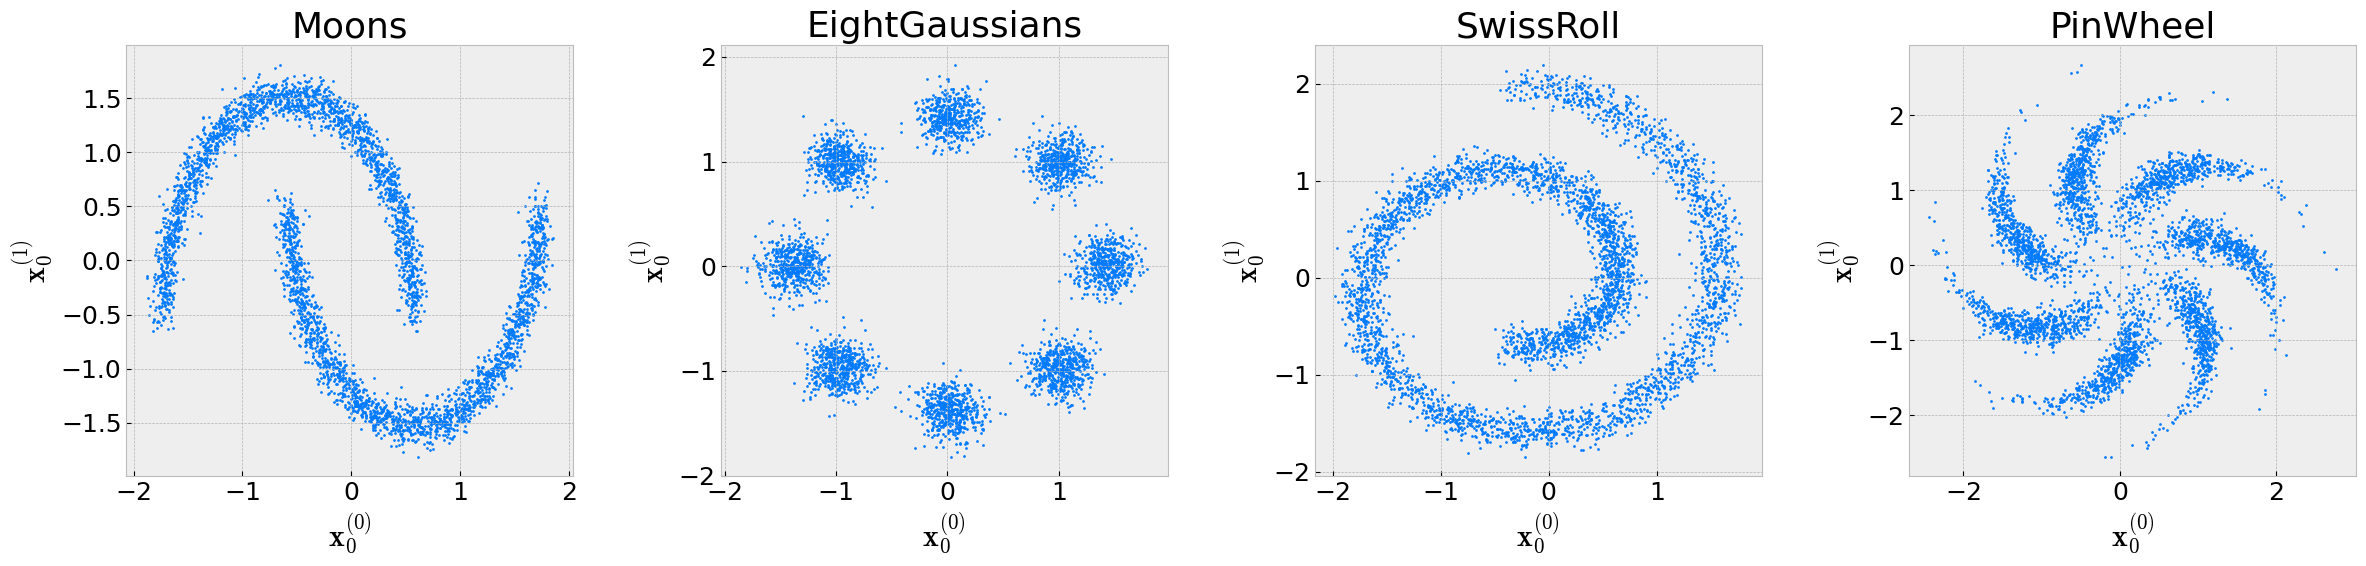

In [5]:
fig, axes = plt.subplots(1, len(names_dataset), figsize=(6 * len(names_dataset), 6),
                         gridspec_kw={'width_ratios': [1] * len(names_dataset)})

for i in range(len(names_dataset)):
    name = names_dataset[i]
    x = datasets[name]
    if len(datasets) != 1:
        axes[i].scatter(x[:, 0], x[:, 1], c="#007aff", s=2)
        axes[i].set(title=f"{name}",
                    xlabel="$\mathbf{x}_0^{(0)}$", ylabel="$\mathbf{x}_0^{(1)}$")
    else:
        axes.scatter(x[:, 0], x[:, 1], c="#007aff", s=2)
        axes.set(title=f"{name}",
                 xlabel="$\mathbf{x}_0^{(0)}$", ylabel="$\mathbf{x}_0^{(1)}$")

plt.tight_layout()
plt.show()

In [6]:
class EpsilonThetaNetwork(nn.Module):
    """
    Mạng xấp xĩ epsilon
    phần này thiết kế tùy tập dữ liệu
    (do it yourself :D)
    """

    def __init__(self, n_steps, x_flatten_shape=2,
                 n_embeds=50, device='cpu', dtype=torch.float64):
        """
        Hảm khởi tạo

        :param n_steps: số lượng bước nhảy T = n_steps
        :param x_flatten_shape: số chiều của x0
        :param n_embeds: dành cho layer embed của t
        :param device: thiết bị sử dụng
        :param dtype: kiểu số thực float32 hay float64
        """
        super(EpsilonThetaNetwork, self).__init__()
        self.n_steps = n_steps
        self.n_embeds = n_embeds
        self.device = device
        self.embeds = nn.Embedding(n_steps, n_embeds,
                                   device=device, dtype=dtype)
        self.hidden1 = nn.Sequential(
            nn.BatchNorm1d(2 + n_embeds, device=device, dtype=dtype),
            nn.Linear(2 + n_embeds, 128, device=device, dtype=dtype),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128, device=device, dtype=dtype),
            nn.Linear(128, 64, device=device, dtype=dtype),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64, device=device, dtype=dtype),
            nn.Linear(64, 32, device=device, dtype=dtype),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(32, device=device, dtype=dtype),
            nn.Linear(32, 16, device=device, dtype=dtype),
            nn.Tanh(),
            nn.BatchNorm1d(16, device=device, dtype=dtype),
            nn.LeakyReLU(0.1),
            nn.Linear(16, x_flatten_shape, device=device, dtype=dtype),
        )
        self.concat_layer = nn.Linear(
            x_flatten_shape * 2, x_flatten_shape, device=device, dtype=dtype)

    def forward(self, xt, t):
        """
        Epsilon Theta

        :param xt:
        :param t:
        :return:
        """
        t_embed = self.embeds(t.view(-1, 1))
        v1 = torch.hstack([xt, t_embed.view(xt.size()[0], self.n_embeds)])
        h1 = self.hidden1(v1)
        v2 = torch.hstack([h1, xt])
        epsilon_theta = self.concat_layer(v2)
        return epsilon_theta


class DenoisingDiffusionProbabilisticModel(nn.Module):
    def __init__(self, epsilon_model, n_steps, device):
        super(DenoisingDiffusionProbabilisticModel, self).__init__()
        self.epsilon_model = epsilon_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma2 = self.beta
        self.T = n_steps - 1
        self.n_steps = n_steps

    def sample_q(self, x0, t, epsilon=None):
        """
        Công thức lấy mẫu xt ~ q(xt | x0)

        :param x0:
        :param t:
        :param epsilon:
        :return: xt
        """
        if epsilon is None:
            epsilon = torch.randn_like(x0)

        alpha_bar = self.alpha_bar.gather(-1, t).view(-1, 1)
        mu = torch.sqrt(alpha_bar) * x0
        sigma = torch.sqrt(1 - self.alpha_bar.gather(-1, t).view(-1, 1))

        return mu + sigma * epsilon

    def sample_p(self, xt, t):
        """
        Công thức lấy mẫu xt ~ p(x_{t-1} | x_{t})

        :param xt:
        :param t:
        :return: x_{t-1}
        """
        epsilon_theta = self.epsilon_model(xt, t)
        alpha_bar = self.alpha_bar.gather(-1, t).view(-1, 1)
        alpha = self.alpha.gather(-1, t).view(-1, 1)
        coef = (1 - alpha) / torch.sqrt(1 - alpha_bar)

        mu = 1 / torch.sqrt(alpha) * (xt - coef * epsilon_theta)
        sigma = torch.sqrt(self.sigma2.gather(-1, t).view(-1, 1))
        if t.sum() == 0:
            z = torch.zeros_like(sigma, device=xt.device)
        else:
            z = torch.randn(xt.shape, device=xt.device)
        return mu + sigma * z

    def forward_process(self, x0):
        t = (self.n_steps-1) * torch.ones(size=(x0.shape[0],), dtype=torch.long)
        xt = self.sample_q(torch.tensor(x0), t)
        return xt

    def reverse_process(self, data_size):
        x_t = torch.randn(size=(data_size, 2))
        for i in reversed(range(self.n_steps)):
            t = i * torch.ones(size=(data_size,), dtype=torch.long)
            x_t = self.sample_p(x_t, t)
        return x_t

    def pdf_reverse_samples(self, x, bandwidth=0.05):
        density_data = self.reverse_process(10_000)
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        kde.fit(density_data.detach().numpy())
        return kde.score_samples(x)


def loss_func(x0, model: DenoisingDiffusionProbabilisticModel):
    # [Pseudocode T4] lấy ngẫu nhiên bước nhảy thời gian
    t = torch.randint(0, model.n_steps - 1, (x0.shape[0],), device=x0.device, dtype=torch.long)
    # [Pseudocode T5] lấy ngẫu nhiên epsilon có phân bố chuẩn tắc nhiều chiều
    # Note: chổ này vẫn tương đương lấy MultivariateNormal(0, I)
    # viết vầy cho tiện, đơn giản (hơi mẹo tí)
    epsilon = torch.randn_like(x0, device=x0.device)
    xt = model.sample_q(x0, t, epsilon=epsilon)
    epsilon_theta = model.epsilon_model(xt, t)
    # [Pseudocode T7] 7.1 chổ này là tính loss
    return F.mse_loss(epsilon, epsilon_theta)

In [7]:
def train_denoise_diffusion_probabilistic_model(
    dataset, test_size, batch_size, n_epochs, verbose=False):
    """Huấn luyện mô hình

    :param dataset: tập dữ liệu X gồm D cột và n hàng
    :param test_size: tỉ lệ validation
    :param batch_size: batch_size huấn luyện
    :param n_epochs: số bước tối ưu
    :param verbose: có in ra dài dòng lê thê kooooo
    """
    x_train, x_val = train_test_split(dataset, test_size=test_size)

    train_dataset = DataLoader(x_train, batch_size=batch_size, shuffle=True)
    validation_dataset = DataLoader(x_val, batch_size=batch_size, shuffle=True)

    # Tùy chỉnh model, bạn có thể tăng, giảm độ phức tạp n_couple_layers tùy muốn
    model = DenoisingDiffusionProbabilisticModel(
        EpsilonThetaNetwork(n_steps=n_steps, device=device, dtype=dtype),
        n_steps=n_steps, device=device)

    # Thiết lập thuật toán tối ưu
    optimizer = torch.optim.RMSprop(model.epsilon_model.parameters())

    loss_train = []
    loss_validation = []

    for epoch in tqdm.tqdm(range(n_epochs)):
        train_loss = []
        validation_loss = []

        # [Pseudocode T3] x0 ~ q(x0) lấy mẫu huấn luyện
        for step, x_batch_train in enumerate(train_dataset):
            model = model.train()

            if model.training:
                optimizer.zero_grad()
                loss_value = loss_func(x_batch_train, model)
                # [Pseudocode T7] 7.2 chổ này là cập nhật vector gradient
                loss_value.backward()
                optimizer.step()

            train_loss.append(loss_value.item())

        for step, x_batch_validation in enumerate(validation_dataset):
            model = model.eval()
            with torch.no_grad():
                loss_value = loss_func(x_batch_train, model)
                validation_loss.append(loss_value.item())

        train_mse = np.mean(train_loss)  # hơi lười =))
        validation_mse = np.mean(validation_loss)  # hơi lười =))

        loss_train.append(train_mse)
        loss_validation.append(validation_mse)

        if verbose:
            tqdm.tqdm.write(
                f"[{str(epoch).zfill(4)}] " +
                f"train loss {'{:.6f}'.format(train_nll_per_sample)} " +
                f"val loss {'{:.6f}'.format(validation_nll_per_sample)}")

    return model, loss_train, loss_validation


dict_model = {}

for i in range(len(datasets)):
    name = names_dataset[i]
    dataset = datasets[name]
    model, loss_train, loss_validation = train_denoise_diffusion_probabilistic_model(
        dataset, test_size=0.25, batch_size=1024, n_epochs=n_epochs, verbose=False)
    dict_model[name] = model, loss_train, loss_validation

100%|███████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 74.67it/s]


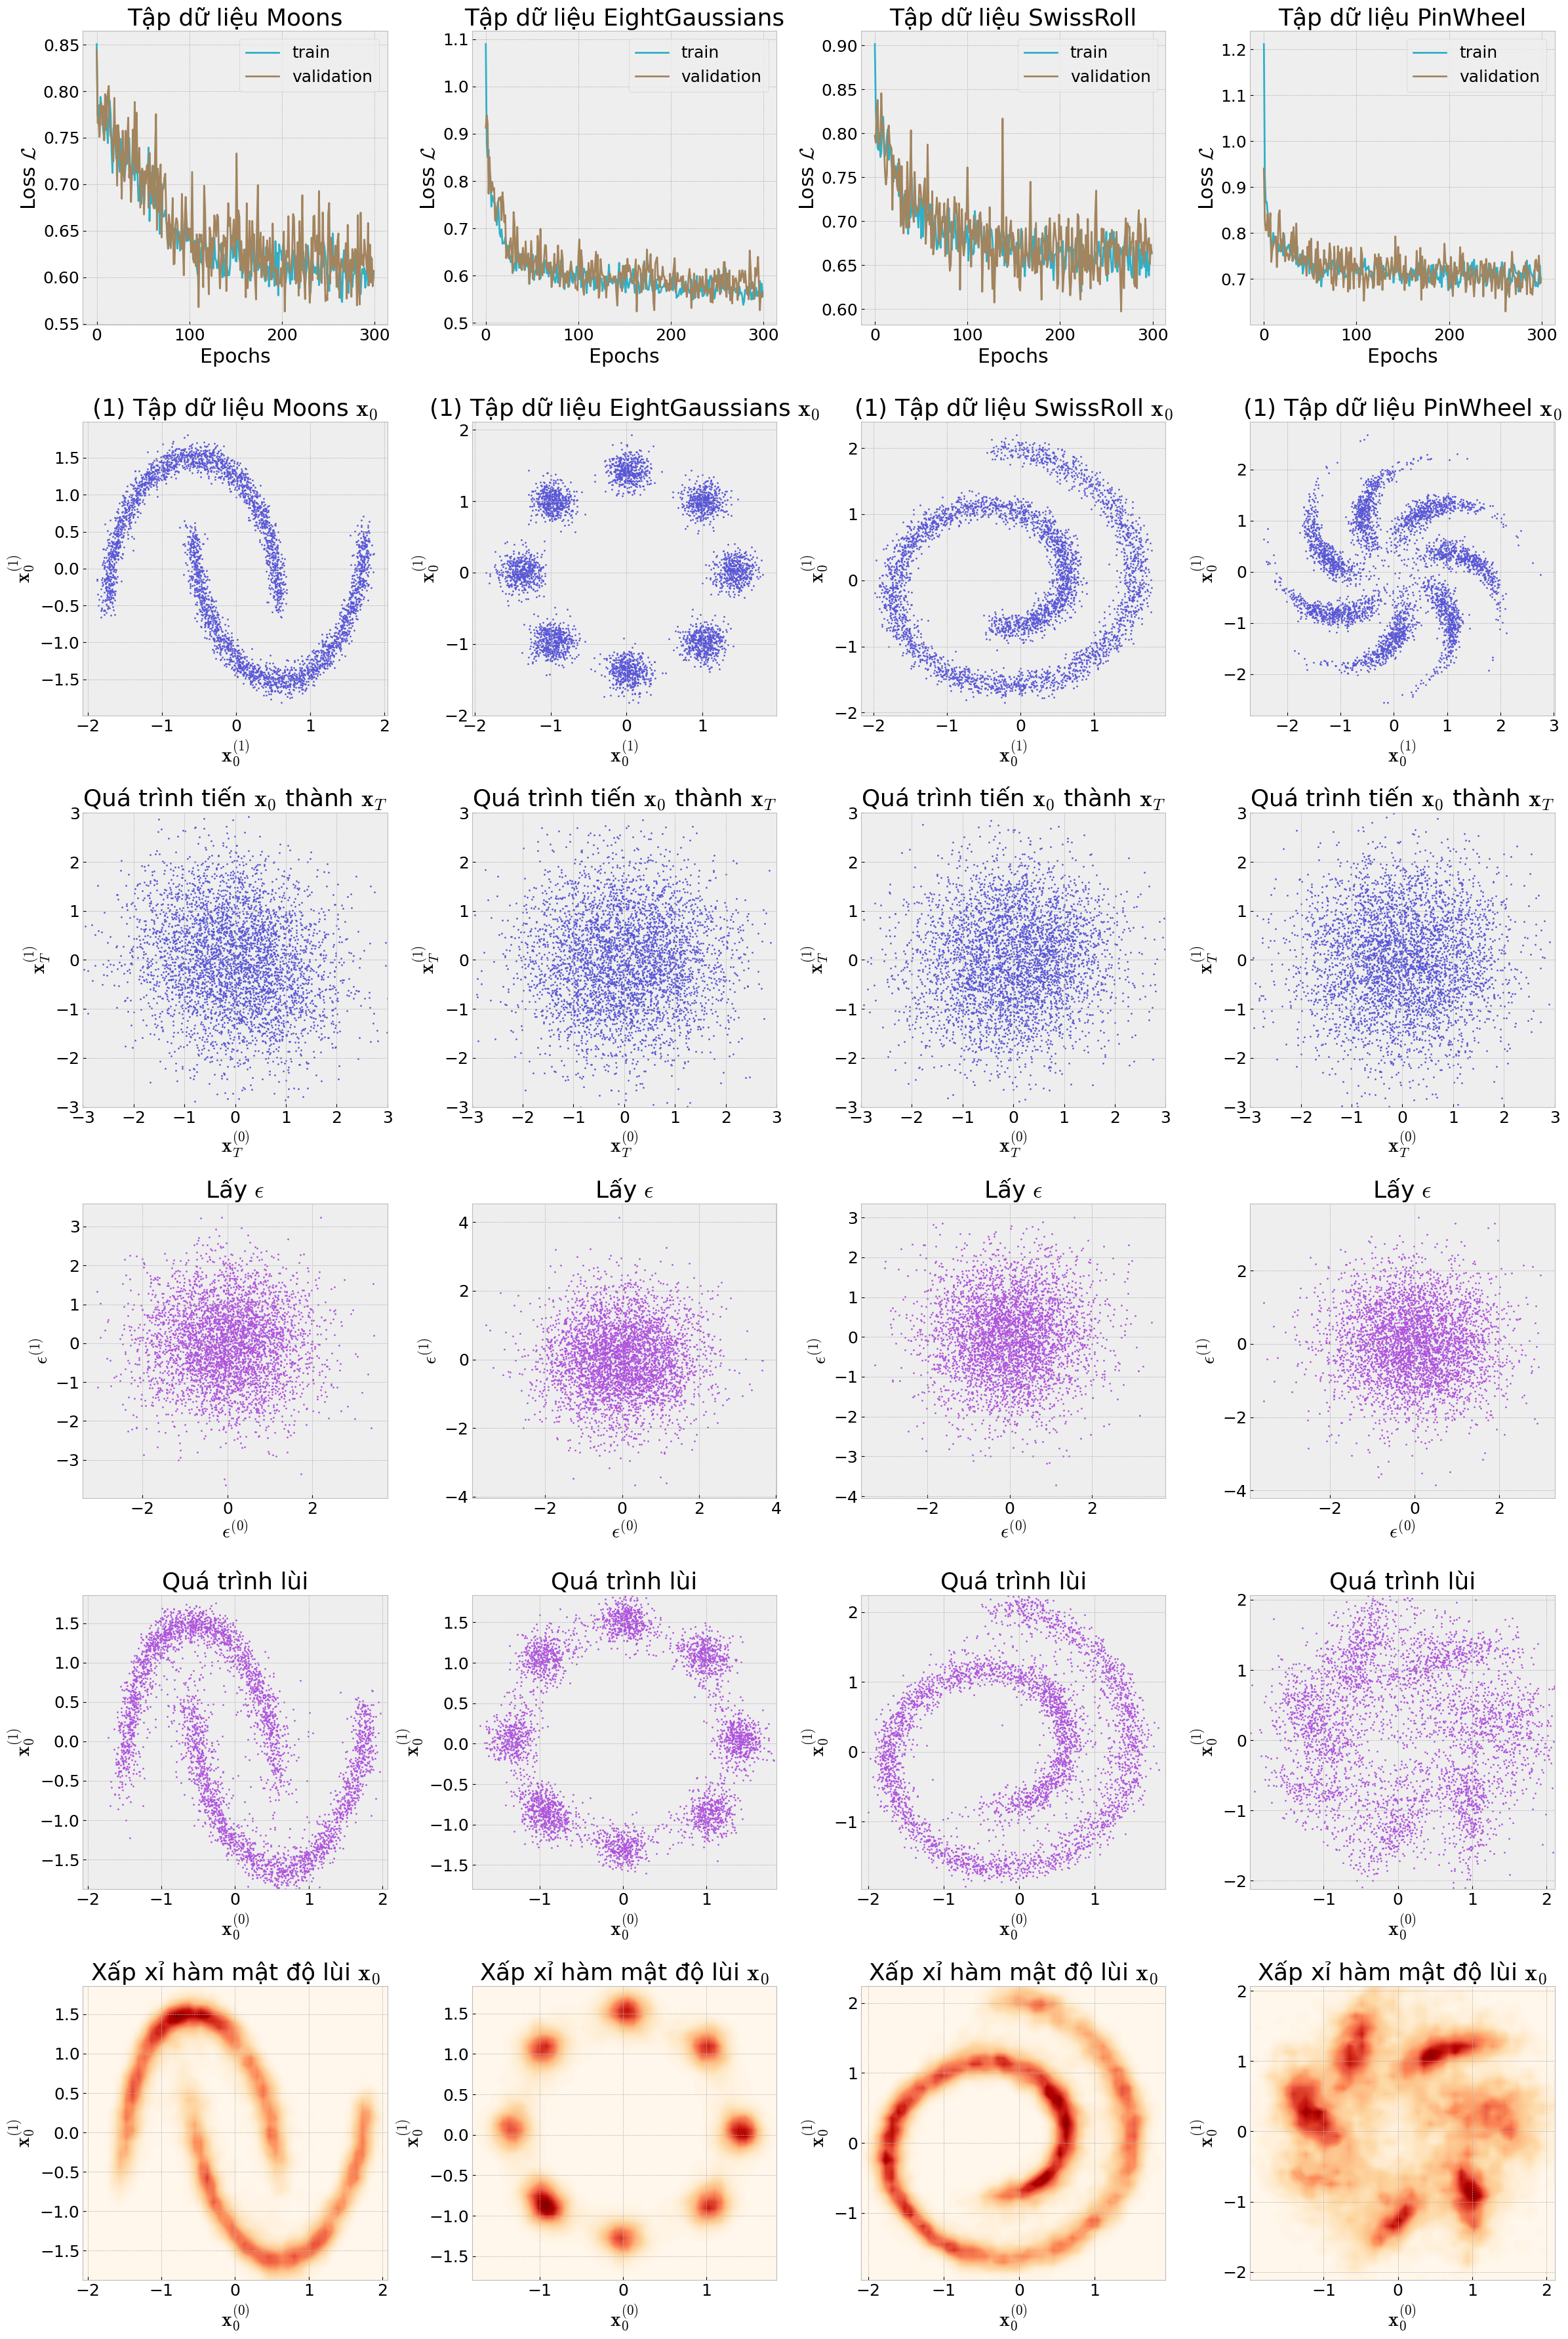

In [8]:
def visualize_for_dataset(name, axes, idx_axes, model, loss_train, loss_validation):
    """Trực quan hóa dành cho ax tương ứng
    """
    x_dataset = datasets[name]

    # Tính toán chổ này padding cho đẹp :D
    min_x0 = np.percentile(x_dataset[:, 0], 2.5)
    min_x1 = np.percentile(x_dataset[:, 1], 2.5)
    max_x0 = np.percentile(x_dataset[:, 0], 97.5)
    max_x1 = np.percentile(x_dataset[:, 1], 97.5)
    padding_x0 = (max_x0 - min_x0) / 10
    padding_x1 = (max_x1 - min_x1) / 10
    min_x0 = min_x0 - padding_x0
    max_x0 = max_x0 + padding_x0
    min_x1 = min_x1 - padding_x1
    max_x1 = max_x1 + padding_x1

    axes[0, idx_axes].plot(loss_train, color="#30b0c7")
    axes[0, idx_axes].plot(loss_validation, color="#a2845e")
    axes[0, idx_axes].set(
        title=f"Tập dữ liệu {name}",
        xlabel="Epochs", ylabel="Loss $\mathcal{L}$")
    axes[0, idx_axes].legend(["train", "validation"], loc="upper right")

    # Biến đỗi x_0 -> x_t từ tập dữ liệu
    z_dataset = model.forward_process(x_dataset)
    axes[1, idx_axes].scatter(x_dataset[:, 0], x_dataset[:, 1], color="#5856d6", s=2)
    axes[1, idx_axes].set(
        title="(1) Tập dữ liệu " + name + " $\mathbf{x}_0$",
        xlabel="$\mathbf{x}_0^{(1)}$", ylabel="$\mathbf{x}_0^{(1)}$")

    axes[2, idx_axes].scatter(z_dataset[:, 0], z_dataset[:, 1], color="#5856d6", s=2)
    axes[2, idx_axes].set(
        title="Quá trình tiến $\mathbf{x}_0$ thành $\mathbf{x}_T$",
        xlabel="$\mathbf{x}_T^{(0)}$", ylabel="$\mathbf{x}_T^{(1)}$")
    axes[2, idx_axes].set_xlim([-3, 3])
    axes[2, idx_axes].set_ylim([-3, 3])

    # Lấy mẫu epsilon từ N(0, I)
    z_samples = np.random.normal(size=(len(x_dataset), 2))
    # Biến đổi từ epsilon -> x0
    x_samples = model.reverse_process(len(x_dataset))
    x_samples = x_samples.detach().numpy()
    axes[3, idx_axes].scatter(z_samples[:, 0], z_samples[:, 1], color="#af52de", s=2)
    axes[3, idx_axes].set(
        title="Lấy $\epsilon$",
        xlabel="$\epsilon^{(0)}$", ylabel="$\epsilon^{(1)}$")
    axes[4, idx_axes].scatter(x_samples[:, 0], x_samples[:, 1], color="#af52de", s=2)
    axes[4, idx_axes].set(
        title="Quá trình lùi",
        xlabel="$\mathbf{x}_0^{(0)}$", ylabel="$\mathbf{x}_0^{(1)}$")
    axes[4, idx_axes].set_xlim([min_x0, max_x0])
    axes[4, idx_axes].set_ylim([min_x1, max_x1])

    # Vẽ countour map
    n_point = 50  # số điểm neo

    x0_lin = np.linspace(min_x0, max_x0, n_point)
    x1_lin = np.linspace(min_x1, max_x1, n_point)

    x0_grid, x1_grid = np.meshgrid(x0_lin, x1_lin)

    x_contour = np.hstack([x0_grid.reshape(n_point ** 2, 1),
                           x1_grid.reshape(n_point ** 2, 1)])
    z_contour = np.exp(model.pdf_reverse_samples(x_contour).reshape(n_point, n_point))
    axes[5, idx_axes].contourf(x0_grid, x1_grid, z_contour, cmap="OrRd", levels=100)
    axes[5, idx_axes].set_xlim([min_x0, max_x0])
    axes[5, idx_axes].set_ylim([min_x1, max_x1])
    axes[5, idx_axes].set(
        title="Xấp xỉ hàm mật độ lùi $\mathbf{x}_0$",
        xlabel="$\mathbf{x}_0^{(0)}$", ylabel="$\mathbf{x}_0^{(1)}$")


fig, axes = plt.subplots(6, len(names_dataset), figsize=(6 * len(names_dataset), 6 * 6),
                         gridspec_kw={'width_ratios': [1] * len(names_dataset)})

for i in range(len(datasets)):
    name = names_dataset[i]
    model, loss_train, loss_validation = dict_model[name]
    visualize_for_dataset(name, axes, i, model, loss_train, loss_validation)

plt.tight_layout()
plt.show()